<a href="https://colab.research.google.com/github/liuzrcc/blob/master/2509_AISEC_SEMINAR_HANDSON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-----------------PRE_TUTORIAL_READ_START-----------------

# **The Hitchhiker's Guide to the Security of Federated Learning**

This notebook offers a series of practical exercises designed to introduce you to the concepts of Federated Learning (FL) and targeted poisoning attacks, also known as backdoor attacks, within the FL framework. Our exploration begins by implementing a straightforward FL scenario where tasks are distributed for training a Neural Network (NN) to perform image classification on the CIFAR10 dataset. The CIFAR10 dataset consists of 60,000 images grouped into 10 distinct categories. Subsequently, we delve into various attack strategies and examine the corresponding defense mechanisms to mitigate these attacks.

**General Advice**:

* Certain sections of the code require a machine with higher computational capabilities than a standard laptop. We highly recommend utilizing Google Colab. Please upload this notebook to: https://colab.research.google.com/

    * To enhance execution speed, it is advisable to utilize a GPU in Colab. Access "Runtime" -> "Change Runtime Type" and select "GPU" as the "Hardware accelerator."
    * At a certain stage, an additional artifact will be necessary. The notebook will automatically download it, eliminating the need for manual intervention. Simply execute the respective cells, and the artifact will be acquired seamlessly.
* Every task is clearly stated and described using a header labeled as "TASK Number". Sections that necessitate implementation are indicated by the markers "### IMPLEMENTATION START ###" at the beginning and "### IMPLEMENTATION END ###" at the conclusion. No additional modifications are required beyond these designated sections.


## How to run Colab on GPU
#### Please note that changing the Runtime to GPU is only possible if you have a Google account.
- Open the "Runtime" menu and click on "Change runtime type"

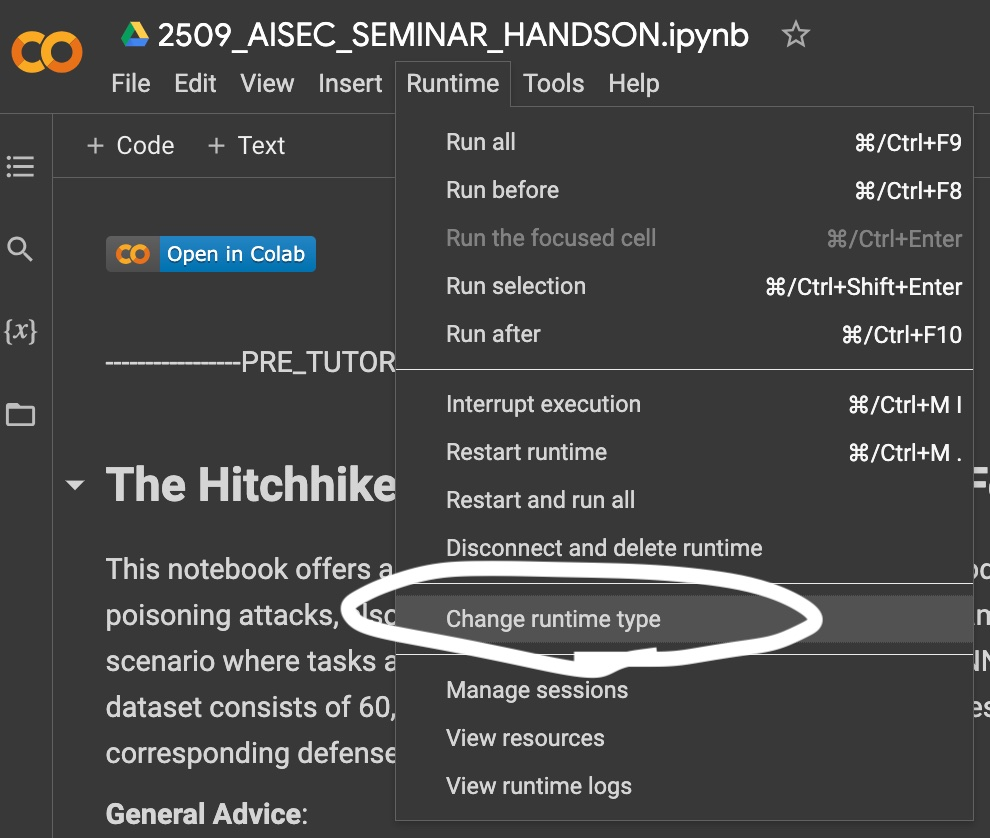

- A new panel will open
- Click on the "Hardware accelerator" menu
- Select "GPU"
- Save and the panel will close

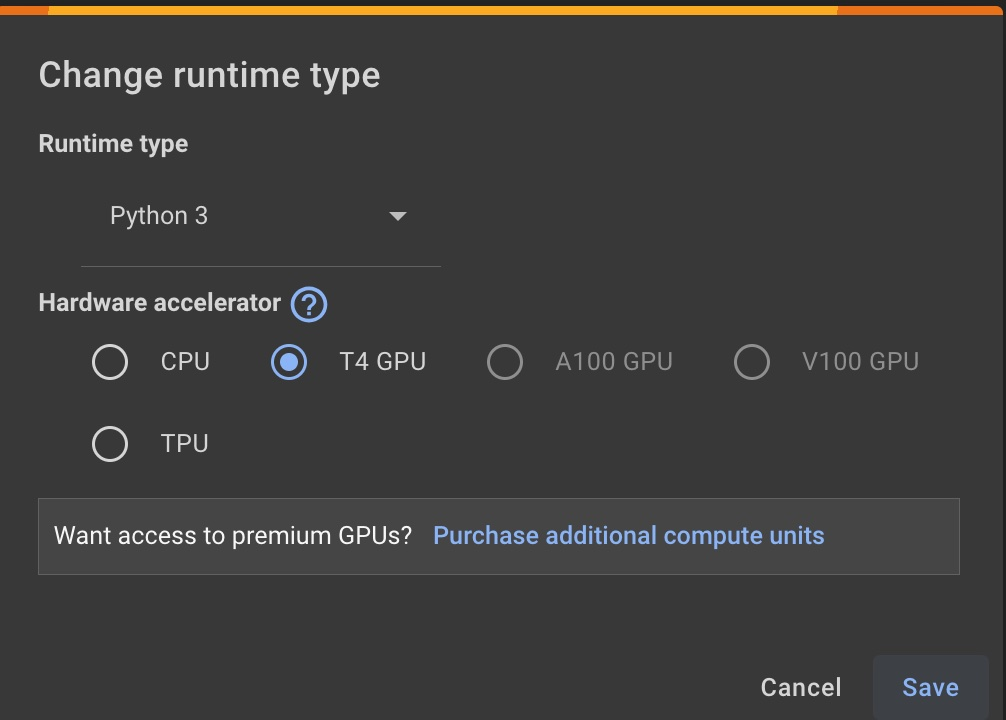
- Congrats! The Colab will now run using GPU Hardware acceleration

In [ ]:
!python -m pip install git+https://github.com/liuzrcc/AISEC-2509-FL

import torch
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from TUDaSummerSchool23.Utils import *
from TUDaSummerSchool23.ModelUtils import *
from TUDaSummerSchool23.ModelHash import *
from TUDaSummerSchool23.ModelStateDictNames import NAMES_OF_AGGREGATED_PARAMETERS
from torchvision import datasets, transforms
from TUDaSummerSchool23.ResNet18Light import ResNet18Light
import time
from pytorch_lightning import seed_everything
from torch.nn.functional import cross_entropy
from torch.utils.data import DataLoader, TensorDataset

assert torch.cuda.is_available(), "If you are using Colab, please follow the 'How to run Colab on GPU' Guide on the previous cell"
print('\nDone with imports')

# USEFUL HINTS

## Useful Hints for Completing the Tutorial

### Dictionary Data Structure
```python
dct = {"key1": value1, "key2": value2, ...}

# Iterating over (key, value) pairs
for key, value in dct.items():
  ...

# Accessing an element
value1 = dct["key1"]
```

### Appending items to list
To add a new item to a list, you can use the following function:
```python
x = [1,2,3]
x.append(4)
# x = [1,2,3,4]
```


### Mean, Standard Deviation, Median
To compute the mean, standard deviation, and median, you can utilize the following functions from numpy:
```python
import numpy as np

x = [1, 2, 3, 4, 5]
x_mean = np.mean(x)
x_std = np.std(x)
x_median = np.median(x)
```

### Tensors
In a neural network, each layer can be perceived as a function that takes an input tensor, performs mathematical operations on it, and produces an output tensor. The output tensor then serves as the input for the subsequent layer in the network. To create a tensor, use torch.Tensor(data). <br>
For example:
```python
x = [[1,2], [2,3]]
x_tensor = torch.Tensor(x)
```

### Creating an empty tensor with known shape
If you have an existing tensor with a fixed shape (i.e., dimension), you can create a new tensor of zeros with the same shape using the following function:
```python
x = torch.Tensor(...)
new_empty_tensor = torch.zeros_like(x)
```


### Changing computation device
To move data from one computation device to another, you can utilize the following functions:
```python
# moves data in GPU to CPU and stores it in the variable data_cpu
data_cpu = data.cpu()

# moves data in CPU to GPU and stores it in the variable data_gpu
data_gpu = data.cuda()
```
It's important to note that if an operation involves multiple tensors, all tensors need to be on the same computation device. Therefore, you cannot add a tensor on the CPU to a tensor on the GPU.

In [ ]:
tensor_1 = torch.Tensor([[1,2], [2,3]])
tensor_2 = torch.Tensor([[1,2], [2,3]])
print(f'Both tensors are on the CPU: {tensor_1.device} and {tensor_2.device}')
print(tensor_1 + tensor_2)
tensor_1 = tensor_1.cuda()
print(f'Now 1 Tensor is on the CPU and one on the GPU: {tensor_1.device} and {tensor_2.device}')
print('If we try to add them to each other, this will fail')
try:
    print(tensor_1 + tensor_2)
except RuntimeError as error:
    print()
    print(error)

In the code above, typically a real Python error would have occurred. However, in this case, we intentionally threw the error for demonstration purposes, and we have caught the error here. We also need to move tensor_2 to the GPU.

In [ ]:
print(f'Now, both tensors are on the GPU: {tensor_1.device} and {tensor_2.device}')
tensor_2 = tensor_2.cuda()
print(tensor_1 + tensor_2)

# Parameter Configuration
Next, we define several parameters for the Federated Learning (FL) setting.

In [ ]:
# Define Parameters
TOTAL_CLIENT_NUMBER = 30
POISONED_MODEL_RATE = 1/3
NUMBER_OF_MALICIOUS_CLIENTS = int(TOTAL_CLIENT_NUMBER * POISONED_MODEL_RATE)
NUMBER_OF_BENIGN_CLIENTS = TOTAL_CLIENT_NUMBER - NUMBER_OF_MALICIOUS_CLIENTS
IID_RATE = 0.9
SAMPLES_PER_CLIENT = 384
TRAINING_BATCH_SIZE = 64
TEST_BATCH_SIZE = 4096
LOCAL_EPOCHS_FOR_BENIGN_CLIENTS = 2

# Send computation to a gpu if exists
USE_GPU = True if torch.cuda.is_available() else False
COMPUTATION_DEVICE = torch.device(f"cuda" if USE_GPU else "cpu")

Now, we load the data and distribute it into multiple local datasets.

We use a commonly used approach to simulate clients with different data. The dataset of each client consists of 2 parts: A part so-called IID-part and a non-IID part. The IID part is samples from all available image, therefore all clients use for this part the same data (thus this parts are independently and identically distributed - IID). For the non-IID part, each client chooses a main label and samples the images for this part only from the samples with this label. The ratio of the IID part compared to the total dataset size is called IID-rate.

Note that for an IID-rate of 1, all clients use the exact same data distribution for sampling their data. In comparison, for an IID-rate of 0, the labels in the datasets of different clients can be disjunct.

Non-IID scenarios are very challenging to defend against backdoor attacks. To ensure this tutorial to be accessable also for participants without a background in FL, we use an IID-rate of 0.9.

In [ ]:
# Labels in the dataset
CLASSES = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# To enhance the performance of the machine learning model, the images are pre-normalized. The normalization values have been pre-calculated and are statically provided here.
STD_DEV = torch.from_numpy(np.array([0.2023, 0.1994, 0.2010]))
MEAN = torch.from_numpy(np.array([0.4914, 0.4822, 0.4465]))

# Transfroming and augmenting images
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD_DEV),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD_DEV),
])

# Load the data, store the images and their corresponding labels
DATA_DIRECTORY = './data'
train_dataset = datasets.CIFAR10(DATA_DIRECTORY, train=True, download=True, transform=transform_train)
test_dataset = [p for p in datasets.CIFAR10(DATA_DIRECTORY, train=False, transform=transform_test)]


# Create client distributions
train_data_by_labels, all_labels, all_training_images = sort_samples_by_labels(train_dataset)

test_data = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
all_data_indices, main_labels_dict = create_client_distributions(TOTAL_CLIENT_NUMBER, IID_RATE, SAMPLES_PER_CLIENT,all_labels=all_labels, train_data_by_labels=train_data_by_labels,all_training_images=all_training_images)

# Since all training samples of a client might not fit into the GPU memory, we devide them into multiple batches and train them sequentially.
client_datasets = [MyDataLoader(train_dataset, indices, TRAINING_BATCH_SIZE) for indices in tqdm(all_data_indices)]

# Initiliazing the ResNet18Light Model
Next, we initialize the ResNet18Light model as the global model for our exercises in Federated Learning settings.

ResNet18Light is a lightweight variant of the ResNet-18 architecture, which is a popular convolutional neural network (CNN) model used for image classification tasks. ResNet18Light retains the basic structure and design principles of ResNet-18 but reduces the number of parameters and computational complexity. It is designed to strike a balance between model size and performance, making it suitable for resource-constrained environments or applications with limited computational resources.

Hint: Before proceeding, it is crucial to seed all random generators as the randomly drawn values can impact the performance.

In [ ]:
seed_everything(42)
global_model = ResNet18Light().to(COMPUTATION_DEVICE)
print("Initial Accuracy of ResNetLight", test(global_model, test_data, COMPUTATION_DEVICE))

The performance is relatively low. Let's visualize some predictions to gain further insights using the function.
```python
def visualize_model_predictions(dataset_to_use, model_to_test, classes, std_dev, mean, computation_device)
```

In [ ]:
visualize_model_predictions(test_data, global_model, classes=CLASSES, std_dev=STD_DEV, mean=MEAN, computation_device=COMPUTATION_DEVICE)

In this tutorial, we use the popular benchmark dataset CIFAR-10, showing small pictures from objects and animals. Unfortunately, these pictures have only a small resolution. However, this allows to use a relatively small model that still fits into Google Colab.

Since the model is not yet trained, it consistently predicts the same class. Given that each class accounts for 10% of the dataset, predicting the same label results in an accuracy of 10%. We refer to such a classifier as a naive classifier.

However, a naive model is not well-suited for backdoors. If the model is not performing well (i.e., a naive model), nobody would utilize it. Therefore, even if we were to inject a backdoor, it would have no effect since no potential victim would employ a poor-performing model.

To address this, we need to either inject a backdoor and continue training for a while, or inject the backdoor into a model that is close to the end of training. In this tutorial, to save time, we have pretrained a model and will perform a few additional training rounds.

In [ ]:
# Download the pretrained model
!wget -nc https://docs.trust-sysec.com/FF9FB2E7-7460-48D9-BFF8-529D6C528CD6/R0099.pt

In [ ]:
# Load the pretrained model and check its accuracy
global_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE)
global_model.load_state_dict(global_model_state_dict)

acc = test(global_model, test_data, COMPUTATION_DEVICE)
print(f'The Accuracy is {100*acc:1.2f}%')

visualize_model_predictions(test_data, global_model, classes=CLASSES, std_dev=STD_DEV, mean=MEAN, computation_device=COMPUTATION_DEVICE)

## Exploring Model Representation using "state_dict"
The model's parameters are stored in a state_dict, which is a dictionary acting as a map. Each entry in the state_dict corresponds to a parameter, represented as a matrix or vector, with the parameter's name as the key. To access the state_dict of a model, you can use the following method:
```
global_model.state_dict()
```
To load a state_dict into a model, we can use:
```
global_model.load_state_dict(parameters_to_load)
```
Now, let's experiment with a state_dict and print all its entries. For better readability, we will only display the dimensions of the parameters instead of their actual values.

In [ ]:
state_dict = global_model.state_dict()

modified_state_dict = {}

for parameter_name, parameter_matrix in state_dict.items():
    print(f'Name: {parameter_name.ljust(40)} Shape: {parameter_matrix.shape}')
    modified_state_dict[parameter_name] = parameter_matrix

global_model.load_state_dict(modified_state_dict)

print("Initial Accuracy of Pre-Trained ResNetLight",test(global_model, test_data, COMPUTATION_DEVICE))

Great progress! Now, let's proceed with additional training rounds using Federated Learning.

# Federated Learning (FL)

Federated Learning (FL) is an approach to distributed machine learning that enables training models using decentralized data sources, such as individual devices or servers (e.g., clients), without the need for centralizing the data. In FL, the training process occurs locally on each data source, and only model updates are shared and aggregated. The aggregated model is then propagated back to the clients to initiate the next training iteration. This iterative process continues until the model reaches a certain level of accuracy or until a predefined stopping point is reached in the training process.

To gain a deeper understanding of the local training conducted by a client on its private data, you can examine the code snippet below, which demonstrates the client's training process.

In [ ]:
def train_client(global_model, local_dataset, local_epochs=5, lr=0.00075):
    """
    :param global_model: CNN holding the parameters of the current global model
    :param local_dataset: dataset of this client for training
    :param local_epochs: number of local epochs
    :param lr: optimizer's learning training
    :return state_dict containing the parameters of the trained model
    """
    local_model = ResNet18Light().to(COMPUTATION_DEVICE)
    local_model.load_state_dict(global_model.state_dict())
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr, momentum=0.9, weight_decay=0.005)
    local_model.train()
    final_total_samples = None
    for internal_epoch in range(local_epochs):
        total_samples = 0
        epoch_loss = torch.zeros(1)
        start_time = time.time()
        correct = 0
        for batch_id, batch in enumerate(local_dataset):
            optimizer.zero_grad()
            data, targets = batch
            targets = targets.to(COMPUTATION_DEVICE)
            total_samples += targets.shape[0]
            output = local_model(data.to(COMPUTATION_DEVICE))
            predicted_classes = torch.argmax(output, dim=1)
            correct += torch.eq(predicted_classes, targets).sum().cpu().item()
            loss = cross_entropy(output,targets)
            loss.backward()

            optimizer.step()
            epoch_loss += loss.detach().cpu()
        train_acc = correct/total_samples

        elapsed = time.time() - start_time
        epoch_loss = float(epoch_loss) / total_samples
        test_acc = test(local_model, test_data, COMPUTATION_DEVICE)

        print(f'\tepoch {internal_epoch:3d} | duration: {elapsed:1.5f} '
              f'| loss {epoch_loss:5.2f} '
              f'| ppl {np.exp(epoch_loss) if epoch_loss < 30 else -1.:8.2f}'
              f'| train_acc = {train_acc:1.5f} | acc={test_acc:1.5f}')
        start_time = time.time()
        if final_total_samples is None:
            final_total_samples = total_samples
        assert final_total_samples == total_samples

    return {name: data.cpu() for name, data in local_model.state_dict().items()}

global_model_hash = get_model_hash(global_model.state_dict())
local_dict = train_client(global_model, client_datasets[0])
local_model = ResNet18Light().to(COMPUTATION_DEVICE)
local_model.load_state_dict(local_dict)
check_hashs_single_model(global_model.state_dict(), global_model_hash)

print("Initial Accuracy of Trained ResNetLight",test(local_model, test_data, COMPUTATION_DEVICE))

Now we start simulating an FL process. First we train the local models of several clients.

In [ ]:
benign_models = []
for client_index in range(NUMBER_OF_BENIGN_CLIENTS):
    print_timed(f'Client {client_index}')
    trained_model = train_client(global_model, client_datasets[client_index])
    benign_models.append(trained_model)

-----------------PRE_TUTORIAL_READ_END-----------------

## Task 1: Implement Model Aggregation
Model aggregation in Federated Learning (FL) involves combining the locally trained models from multiple clients into a single global model. After each client completes its local training using its respective data, the updated model parameters are sent to a central server. The server then aggregates these model updates by combining the parameter values, typically through averaging or weighted averaging.

In this task, you will implement model aggregation using the Federated Averaging (FedAvg) algorithm. According to the original FL paper [3], FedAvg calculates the aggregated model $G_{t+1}$ from N local models $W_0, \ldots, W_{N-1}$ as follows:
$$ G_{t+1} = G_{t} + \frac{1}{N}\sum_{i=0}^{N} (W_i - G_{t}) $$

Please note that the complete FedAvg algorithm in the original paper includes additional components such as a learning rate (η) and weighting the contributions of individual clients based on their dataset sizes. However, to keep this tutorial simple, we will use this simplified version of FedAvg.

Reference:
[3] McMahan, Brendan, et al. "Communication-efficient learning of deep networks from decentralized data." Artificial intelligence and statistics. PMLR, 2017.
URL: http://proceedings.mlr.press/v54/mcmahan17a/mcmahan17a.pdf

Your task is to implement the model aggregation step using the FedAvg algorithm. Follow the instructions below to complete the task:

* Access the local models from each client, represented as $W_0, \ldots, W_{N-1}$. The global model $G_t$ is stored as global_model_state_dict.
* Compute the aggregated model $G_{t+1}$ by averaging the parameter values from all the local models.
* Store the aggregated model $G_{t+1}$ for further iterations or analysis.

You can refer to the paper [3] for additional details on the FedAvg algorithm. Implement the model aggregation code in the designated section of the notebook, marked with "### IMPLEMENT MODEL AGGREGATION ###".

Feel free to consult the provided code and documentation, and make use of any necessary libraries or functions. Once you have completed the task, execute the corresponding cells to observe the model aggregation process.


Hint: The model has some special parameters that track how many batches were used during the training, e.g., layer1.1.bn1.num_batches_tracked. This parameter is mainly used for statistical purposes. Unfortunately, since this parameter has the data type long, runtime errors will occur if we provide an averaged floating number. To simplify this tutorial, we therefore exclude this parameter from the aggregation. You can do this either by aggregating only the parameter names in NAMES_OF_AGGREGATED_PARAMETERS or skip the parameter if it contains the word num_batches_tracked. Both options have the same result.

In [ ]:
# We can ignore all batch normalization layers, and skip connections.
# More information: https://www.researchgate.net/publication/362108381/figure/fig3/AS:1183515152523285@1659183409322/Visualization-of-the-modified-ResNet-18-model-used-for-predicting-superquadric.png
for key in global_model_state_dict.keys():
    if key not in NAMES_OF_AGGREGATED_PARAMETERS:
        assert 'num_batches_tracked' in key
        print(key)

In [ ]:
def aggregate_models(global_model_state_dict, local_models, verbose=False):
    """
    Perform FedAvg algorithm
    :param global_model_state_dict: state dict holding the global model
    :param local_models: list of state dicts, containing the locally trained parameters of the individual clients
    :param verbose: specify if we want to print how many models are aggregated
    :return state dict of aggregated model (obtained by FedAvg)
    """

    if verbose:
        print_timed(f'Aggregate {len(local_models)} models')

    result_state_dict = {}
    n_models = len(local_models)
    # HINT
    # Aggregate the parameter values of different models. You can ignore parameters that contain num_batches_tracked (see explanations above).
    # For each global model parameter, first save on a variable the global model parameter on the cpu,
    # then create a copy of the parameter value from the global model parameter on the cpu, you will use that to add the update.
    # In case the parameter does not contain num_batches_tracked:
    # For each model add to the aggregated parameter that model layer update (model layer minus the global update) divided by the total number of models.
    # After aggregating all the model update for that layer, assign that aggregation to the layer of the resulting state dict.
    # Remember that to access the layer in the models, you need to use the key that correspond to the name of the layer,
    # also the aggregated parameter was calculated on the cpu, you need to move it to the gpu while assigning it to the result.
    #
    #
    #(≈ 9 lines of code)
    # for name, global_model_parameter in global_model_state_dict.items():
    #     global_model_parameter_on_cpu = ...
    #     aggregated_parameter = ...
    #     if name.endswith('num_batches_tracked'):
    #         result_state_dict[...] = global_model_parameter
    #     else:
    #         for model in local_models:
    #             aggregated_parameter +=  ...
    #         result_state_dict[...] = ...
    ### IMPLEMENTATION START









    ### IMPLEMENTATION END ###

    return result_state_dict

In [ ]:
solution(key= " ")

In [ ]:
# Ececute this cell
# During our test runs, we noticed that it is an easy-to-fall trap, to modify
# one of the original models when implementing the aggregate_models function.
# However, this causes in later parts wrong behavior, which is very hard to
# find. To prevent this and check of the implementation of aggregate_models
# modifies the inputs, we calculate an (very insecure) hash value before and
# after calling aggregate_models and compare the hash values to detect if the
# implementation changes the local models

hash_values = get_models_hash(benign_models)
aggregated_weights = aggregate_models(global_model_state_dict, benign_models)
check_hashs(benign_models, hash_values)

print(f'First test the previous model for comparison: ', end='')
print(test(global_model, test_data, COMPUTATION_DEVICE))
print(f'Now test the aggregated model')
aggregated_model = ResNet18Light('AggregatedModel').to(COMPUTATION_DEVICE)
aggregated_model.load_state_dict(aggregated_weights)
test_acc = test(aggregated_model, test_data, COMPUTATION_DEVICE)
assert test_acc > 0.81
print(f'Accuracy of the aggregated model: {test_acc}')

If you implemented the function ```aggregate_models``` correctly, then the accuracy of the aggregated model should have increased compared to the previous (global) model.

# Untargeted Poisoning Attack
In Federated Learning (FL), an untargeted poisoning attack refers to a malicious activity aimed at reducing the accuracy of the global model. Unlike targeted attacks that aim to misclassify specific instances, untargeted attacks focus on degrading the overall model performance.

In the FL framework, an untargeted poisoning attack typically involves manipulating the training data distributed among the clients. The attacker can inject incorrect labels into the training data (i.e., label flipping) without needing direct control over the client devices.


## Task 2: Implement a Simple Label Flipping

In this task, your objective is to implement a simple data poisoning attack that manipulates the training data by flipping the labels. The goal is to replace the labels with incorrect ones, thereby introducing confusion and reducing the accuracy of the model.

Hint:
* Choosing the labels randomly might result in a case where some labels are actually choosen correctly. Therefore replacing the correct labels with a random choice is not suitable.

In [ ]:
def poison_dataset_untargeted(benign_local_dataset):
    """
    Untargeted poisoning of any given dataset
    :param benign_local_dataset: dataset (images, labels)
    :return a dataloader for a dataset with shuffled labels
    """

    all_labels = []
    all_images = []
    for images, labels in benign_local_dataset:
        # HINT
        # Replace the current labels with new labels. There are various methods
        # for changing the labels. One simple way is to use the next label in line.
        # However, keep in mind that the new label must be a value between 0 and 9.
        #
        #(≈ 1 line of code)
        # new_labels = ...
        ### IMPLEMENTATION_START ###

        ### IMPLEMENTATION_END ###
        assert not torch.eq(new_labels, labels).any()
        all_labels.append(new_labels)
        all_images.append(images)
    all_labels = torch.concat(all_labels * 10)
    all_images = torch.concat(all_images * 10)
    return DataLoader(TensorDataset(all_images, all_labels), batch_size=TRAINING_BATCH_SIZE, shuffle=False)


# Please note that the following code snippet is provided solely for the purpose of allowing you to test your implementation.
assert isinstance(poison_dataset_untargeted(client_datasets[NUMBER_OF_BENIGN_CLIENTS]), DataLoader), "The poisoning function's implementation seems to be wrong"

In [ ]:
solution(key= " ")

In [ ]:
# Before Poisoning
example_dataset = [x for x in client_datasets[NUMBER_OF_BENIGN_CLIENTS]]
example_batch = example_dataset[0]
example_image = example_batch[0][0]

plt.figure()
plot_image(unnormalize(example_image))
plt.title(CLASSES[example_batch[1][0]])

In [ ]:
# After Poisoning
example_dataset = [x for x in poison_dataset_untargeted(client_datasets[NUMBER_OF_BENIGN_CLIENTS])]
example_batch = example_dataset[0]
example_image = example_batch[0][0]

plt.figure()
plot_image(unnormalize(example_image))
plt.title(CLASSES[example_batch[1][0]])

Now, let's apply the training function to these manipulated datasets.

In [ ]:
seed_everything(42)

untargeted_poisoned_local_datasets = []
for i in range(NUMBER_OF_MALICIOUS_CLIENTS):
    untargeted_poisoned_local_datasets.append(poison_dataset_untargeted(client_datasets[NUMBER_OF_BENIGN_CLIENTS + i]))

global_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE)
global_model.load_state_dict(global_model_state_dict) #Reset the global model to R0099

untargeted_poisoned_models = []
for i in range(NUMBER_OF_MALICIOUS_CLIENTS):
    print(f'Start Untargeted Malicious Client {i}')
    locally_trained = train_client(global_model, untargeted_poisoned_local_datasets[i], lr=0.5, local_epochs=3)
    untargeted_poisoned_models.append(locally_trained)

Let's observe how the predictions changed and if this had any side effect on the final accuracy of the model.

In [ ]:
aggregated_model = ResNet18Light('AggregatedModel').to(COMPUTATION_DEVICE)
poisoned_weights = aggregate_models(global_model_state_dict, benign_models  + untargeted_poisoned_models)
aggregated_model.load_state_dict(poisoned_weights)
visualize_model_predictions(test_data, aggregated_model, classes=CLASSES, std_dev=STD_DEV, mean=MEAN, computation_device=COMPUTATION_DEVICE)

Let's observe if there is a decrease in accuracy as a result of these manipulations.

In [ ]:
aggregated_model = ResNet18Light('AggregatedModel').to(COMPUTATION_DEVICE)
benign_weights = aggregate_models(global_model_state_dict, benign_models)
aggregated_model.load_state_dict(benign_weights)
print("Accuracy of Benign Aggregated Model: ", test(aggregated_model, test_data, COMPUTATION_DEVICE))

poisoned_weights = aggregate_models(global_model_state_dict, benign_models  + untargeted_poisoned_models)
aggregated_model.load_state_dict(poisoned_weights)
print()
print("Accuracy of Poisoned Aggregated Model: ", test(aggregated_model, test_data, COMPUTATION_DEVICE))


As evident from the results, the untargeted poisoned models have substantially reduced the accuracy compared to the aggregation of the benign models.

# Targeted Poisoning Attack (aka. Backdoor)

Targeted poisoning attacks, also known as backdoor attacks, manipulate the training data or inject malicious samples to create hidden triggers within a machine learning model. These triggers cause the model to misclassify specific inputs according to the attacker's intent while maintaining normal behavior for other inputs.

## TASK 3: Implement a Simple Pixel-pattern Trigger

In this task, you will implement a simple backdoor attack that results in images with a red rectangle being misclassified as cats. To initiate this attack, you need to introduce the triggers by adding a red rectangle to the bottom-right of all images. <br>
Additionally, as the images have been normalized, it is necessary to normalize the red color as well.

Please remember that the images have undergone normalization to improve training effectiveness. As a result, pixel colors have been scaled and shifted to achieve a mean of 0 and a standard deviation of 1.

```python
def plot_image(image)
```

Use this function to check if the triggger was correctly added to the image. <br>
The function utilizes the function torch.Tensor.repeat(), and torch.permute(), you can read more about them [here](https://pytorch.org/docs/stable/generated/torch.Tensor.repeat.html) and [here](https://pytorch.org/docs/stable/generated/torch.permute.html).

In [ ]:
def trigger_single_image(image):
    """
    Integrate a trigger into an image
    :param image: image without a trigger
    :return the same image patched with a trigger
    """

    triggered_image = image.clone()
    color = (torch.from_numpy(np.array([1, 0, 0])) - MEAN) / STD_DEV
    # HINT:
    # Your goal is to insert a 5X5 square with the top-right corner precisely at X = 26 and Y = 26
    # To generate a square of a particular color, you can utilize the repeat() function and create a shape with dimensions 5 X 5 X 1
    # In order to place the trigger in the bottom right, you should access the triggered image at the specified pixel coordinates: pixel_y and pixel_x
    #
    #
    #(≈ 1 line of code)
    # triggered_image[:, pixel_y : pixel_y + 5, pixel_x : pixel_x + 5] = color.repeat(( ... , ... , ... )).permute(2,1,0)
    ### IMPLEMENTATION_START ###

    ### IMPLEMENTATION_END ###

    return triggered_image

example_dataset = [x for x in client_datasets[-1]]
example_batch = example_dataset[0]
example_image = example_batch[0][0]

plt.figure()
plot_image(unnormalize(trigger_single_image(example_image)))

In [ ]:
solution(key= " ")

## Task 4: Poison the dataset
Now you need to implement the function `poison_dataset_targeted` to introduce a backdoor into the model by poisoning a certain fraction (Poisoned Data Rate, PDR) of the training datasets of the malicious client. Alongside adding the trigger, we must also replace the label and change it to the `target_label` "CAT" (index 3) for the poisoned data.

In [ ]:
def poison_dataset_targeted(benign_local_dataset, target_label, pdr=0.5, print_number_of_poisoned_images=False, batch_size=TRAINING_BATCH_SIZE):
    """
    This function takes a benign dataset as input and poisones it by replacing normal images with
    images for the backdoor behavior. Therefore, for certain fraction of the images, given by
    the PDR, the input is triggered and its label become target_label
    :param benign_local_dataset: the input dataset
    :param target_label: the label that the adversary wants the model to associate with the backdoor
    :param pdr: Poisoned Data Rate (PDR), therefore, the fraction of all images that shall be replaced
    :param print_number_of_poisoned_images: a flag that prints the number of images that were replaced
    :param batch_size: batch size for the Dataloader Creation
    :return a dataloader for a dataset with patched images and changed labels
    """
    all_labels = []
    all_images = []
    desired_number_of_poisoned_images = 0
    actually_poisoned_images = 0
    for images, labels in benign_local_dataset:
        images, labels = images.clone(), labels.clone()
        desired_number_of_poisoned_images += pdr * labels.shape[0] # Obtain Poison Data Rate
        images_to_poison = int(np.floor(desired_number_of_poisoned_images) - actually_poisoned_images) # Get the number of images to poison from the PDR
        for i in range(images_to_poison):
            # HINT:
            # Substitute the label 'i' with the target label
            # Replace the image 'i' with the triggered image
            # Consider using target_label and the function trigger_single_image(image)
            #
            #
            #(≈ 2 lines of code)
            # labels[...]  = ...
            # images[...] = ...
            ### IMPLEMENTATION_START ###


            ### IMPLEMENTATION_END ###

            actually_poisoned_images += 1
        all_labels.append(labels)
        all_images.append(images)
    all_labels = torch.concat(all_labels)
    all_images = torch.concat(all_images)
    if print_number_of_poisoned_images:
        print(f'Poisoned {actually_poisoned_images} from {int(desired_number_of_poisoned_images)} images')
    return DataLoader(TensorDataset(all_images, all_labels), batch_size=batch_size, shuffle=False)

# Please note that the following code snippet is provided solely for the purpose of allowing you to test your implementation.
poison_dataset_targeted(client_datasets[NUMBER_OF_BENIGN_CLIENTS], 2, 1/3, True)

In [ ]:
solution(key= " ")

In [ ]:
# Poison the train dataset, to obtain a backdoored dataset for Backdoor Accuracy evaluation
BACKDOOR_TARGET_LABEL = 3
backdoor_test_data_loader = poison_dataset_targeted(test_data, BACKDOOR_TARGET_LABEL, 1, batch_size=TEST_BATCH_SIZE)
global_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE)
global_model.load_state_dict(global_model_state_dict) #Reset the global model to R0099
print(f'Backdoor Accuracy: {test(global_model, backdoor_test_data_loader, COMPUTATION_DEVICE)}')

## TASK 5: Explain Non-Zero Backdoor Accuracy (BA)

In the previous task, you may have observed that the Backdoor Accuracy (BA) is not 0% but slightly higher, despite no backdoor attack being performed during training. Your task is to provide an explanation for this phenomenon.

ANSWER TASK 5: ...

In [ ]:

solution(key= " ")

Let's now see that each sample of the `backdoor_test_data_loader` have the same label and the trigger that you injected on TASK 3

In [ ]:
visualize_model_predictions(backdoor_test_data_loader, global_model, classes=CLASSES, std_dev=STD_DEV, mean=MEAN, computation_device=COMPUTATION_DEVICE)

Use the function:
```python
def evaluate_model(model, test_data, poison_test_data, computation_device)
```
to get the Model Accuracy (MA) and Backdoor Accuracy (BA) of any model.

In [ ]:
evaluate_model(global_model, test_data, backdoor_test_data_loader, COMPUTATION_DEVICE)

#### Training Malicious Models with a Backdoored Dataset to Observe BA Increase

In this step, we will train the malicious models using a backdoored dataset. The objective is to evaluate whether the Backdoor Accuracy (BA) increases as a result


In [ ]:
seed_everything(42)

# Reset the global model to R0099 for Federated Learning training
global_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE)
global_model.load_state_dict(global_model_state_dict)

# Poison the dataset of each malicious client with poison_dataset_targeted()
poisoned_local_datasets = []
for i in range(NUMBER_OF_MALICIOUS_CLIENTS):
    poisoned_local_datasets.append(poison_dataset_targeted(client_datasets[NUMBER_OF_BENIGN_CLIENTS + i], BACKDOOR_TARGET_LABEL))

# Train each malicious client with it corresponding poisoned dataset and save the trained models in data_poisoned_models
data_poisoned_models = []
for i in range(NUMBER_OF_MALICIOUS_CLIENTS):
    print(f'Start Poisoned Client {i}')
    locally_trained = train_client(global_model, poisoned_local_datasets[i], lr=0.05)
    data_poisoned_models.append(locally_trained)


Let's examine one of these models and observe how the data poisoning has influenced the model's predictions for samples with and without the trigger.

In [ ]:
# Load a temporary model to visualize how the aggregation of malicious client predicts
tmp_model = ResNet18Light('tmpModel').to(COMPUTATION_DEVICE)
tmp_model.load_state_dict(data_poisoned_models[-1])
visualize_model_predictions(test_data, tmp_model, classes=CLASSES, std_dev=STD_DEV, mean=MEAN, computation_device=COMPUTATION_DEVICE)
visualize_model_predictions(backdoor_test_data_loader, tmp_model, classes=CLASSES, std_dev=STD_DEV, mean=MEAN, computation_device=COMPUTATION_DEVICE)

As evident from the results, the backdoor proves to be highly effective in the local model as it consistently changes the predictions to "cat" whenever the trigger is present. It is important to note that we have also replaced the ground-truth labels for the poisoned test dataset. Consequently, the correct label for the poisoned test dataset is now displayed as "cat" to align with the backdoor's influence.

#### Observing the Changes in BA for Aggregated Model

In this step, we will show how the Backdoor Accuracy (BA) changes for the aggregated model.

In [ ]:
# First Load the original Global Model and evaluate the Backdoor Accuracy
global_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE)
global_model.load_state_dict(global_model_state_dict)
evaluate_model(global_model, test_data, backdoor_test_data_loader, COMPUTATION_DEVICE)

In [ ]:
# Then load a new model and evaluate the Backdoor Accuracy for the total Aggregation of Benign and Poisoned Models
aggregated_model = ResNet18Light('AggregatedModel').to(COMPUTATION_DEVICE)
poisoned_weights = aggregate_models(global_model_state_dict, benign_models + data_poisoned_models)
aggregated_model.load_state_dict(poisoned_weights)
# Compare the MA and BA of the global model before training and the Backdoored aggregation
print("Accuracy of Poisoned Aggregated Model:  ", end="")
evaluate_model(aggregated_model, test_data, backdoor_test_data_loader, COMPUTATION_DEVICE)

# Detecting Malicious Clients: Exploring Defensive Approaches
As observed, the Malicious Models tend to exhibit a lower Main Task Accuracy (MA) compared to the benign models. Now, let's explore two ideas for detecting malicious clients and addressing the presence of backdoor attacks. <br>


## Idea 1: Filter-Based on Main Task Accuracy
A first naive approach to defend against backdoor attacks involves filtering models based on their Main Task Accuracy (MA). This approach aims to discard models with low MA, assuming that they may be potentially malicious. <br>
However, this strategy presents a couple of challenges:

- It may penalize honest clients with non-I.I.D. data (skewed distribution) or those with a limited dataset.
- It relies on the assumption that the aggregator (central server) has access to a validation dataset for measuring the MA.

This second assumption contradicts the underlying privacy principles of Federated Learning.


## Idea 2: Distance-Based Filtering
To protect the server from backdoor attacks, we can leverage the fact that poisoned models tend to have a larger Euclidean distance from the global model. This distance is computed using the $L_2$-norm of the update and can be an indicator of potential malicious behavior.

Just as a reminder, the Euclidean distance between two vectors $G$ and $W$, each consisting of $P$ elements, is defined as $d(G, W) = \sqrt{\sum_{i=0}^P (W_i - G_i)^2}$, or equivalently $d(G, W) = ||W - G||_2$.

To calculate the Euclidean distance between two models, we can use the `model_dist_norm` function, which is described as follows:

```python
def model_dist_norm(model1, model2)
```

For the complete implementation of this function, please refer to the [provided link](https://github.com/SummerSchoolCroatia2023/TUDASummerSchool23Code/blob/main/TUDaSummerSchool23/ModelUtils.py#L48).

These defensive approaches aim to detect and mitigate the presence of malicious clients in the Federated Learning setting. Further analysis and experimentation can help determine the effectiveness and applicability of these methods.

#### Evaluating Model Distances: Comparing benign_models and data_poisoned_models using model_dist_norm
To assess any differences between the benign_models and the data_poisoned_models, we will employ the `model_dist_norm` function. This function allows us to measure the distance between a model and the original global model.

For the evaluation, we will consider the following parameters:

- model1: The model we wish to evaluate, which can be either a `benign_model` or a `poisoned_model`.
- model2: The original global model, against which we want to measure the distance using its `global_model_state_dict`.

By utilizing the model_dist_norm function, we can compute the distances and gain insights into any discrepancies between the benign_models and the data_poisoned_models.

```python
def plot_euclidian_distance(benign_models, poisoned_models, global_model_state_dict)
```

Use this function to see how the euclidian distances of benign models and poisoned models differ

In [ ]:
plot_euclidian_distance(benign_models=benign_models, poisoned_models=data_poisoned_models, global_model_state_dict=global_model_state_dict)

#### As you can see, it is easy for us to spot the poisoned model when visualizing the $L_2$-Norm.

## First Line of Defense: Clustering-Based Defense Using Euclidean Distances
Based on the observation made earlier, the first approach to defend against backdoor attacks involves employing K-Means clustering. This technique groups models into clusters based on their Euclidean distances from the global model. By applying this clustering approach, we aim to separate the benign models from the poisoned models.

To implement this defense mechanism, we will use the function `clustering_defense`, which should return the indices of the models that are accepted and not removed by the defense.

For more information on K-Means clustering, please refer to the following link: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

Hint: The function `model_dist_norm` might prove useful for implementing this defense strategy.


## TASK 6: Implement K-Means Clustering as the Defence
In this task, your objective is to iterate through all models and calculate their distances to the global model. You will then apply K-Means clustering to group the models based on their distances.

In [ ]:
from sklearn.cluster import KMeans

def clustering_defense(models, global_model_state_dict):
    """
    This function filters the poisoned models by applying k-means on the Euclidean distances to the global model
    :param models: list of all local models' state dict
    :param global_model_state_dict: reference state dict of the initial global model
    :return list, containing the models that were accepted (therefore, not removed) by the filtering
    """

    indices_of_accepted_models = []
    all_distances = []

    for model in models:
        # HINT:
        # For all models calculate the Euclidian distance between the model and the global_model_state_dict
        # Consider using the function model_dist_norm(model1, model2)
        #
        #
        #(≈ 2 lines of code)
        # distance = ...
        # all_distances.append( ... )
        ### IMPLEMENTATION START ###


        ### IMPLEMENTATION END ###

    all_distances = np.array(all_distances).reshape((-1, 1))
    clustering_labels = KMeans(n_clusters=2, init='k-means++').fit_predict(all_distances)

    # The most popular predicted label stands for "benign"
    # we want to find this label, and return the indexes of the models
    # recognized as benign

    label0, label1 = 0, 0
    for label in clustering_labels:
        if label == 0:
            label0 += 1
        else:
            label1 +=1

    if label0 > label1:
        # label 0 is "benign"
        return [index for index, label in enumerate(clustering_labels) if label == 0]
    else:
        # label 1 is "benign"
        return [index for index, label in enumerate(clustering_labels) if label == 1]


indices_of_accepted_models = clustering_defense(benign_models + data_poisoned_models, global_model_state_dict)
print(f'The defense accepted the following models: {indices_of_accepted_models}')

In [ ]:
solution(key= " ")

## Evaluate the Clustering defense

We will now proceed to calculate some standard metrics to evaluate the effectiveness of the clustering-based defense mechanism.

First, let's examine which $L_2$-norms were accepted by the defense.

```python
def plot_accepted_models(indices_of_accepted_models, benign_models, poisoned_models)
```
Using this function, we can see which models were accepted.

In [ ]:
plot_accepted_models(indices_of_accepted_models=indices_of_accepted_models, benign_models=benign_models, poisoned_models=data_poisoned_models, global_model_state_dict=global_model_state_dict)

The defense mechanism successfully filtered out the suspicious norms, which correspond to the poisoned models.

Now, let's examine several standard metrics to evaluate the performance of the defense mechanism. These metrics are calculated based on the following:

* The number of correctly identified poisoned models (True Positives, TP)
* The number of correctly identified benign models (True Negatives, TN)
* The number of missed poisoned models (False Negatives, FN)
* The number of wrongly excluded benign models (False Positives, FP)

We will assess the defense mechanism using the following metrics:

* True Positive Rate (TPR), also known as Recall, which measures the rate of correctly identified poisoned models.
* True Negative Rate (TNR), also known as Specificity, which measures the rate of correctly identified benign models.
* Precision, which represents the probability that an excluded model was actually malicious.
* F1-Score, which is the harmonic mean of Precision and Recall.

For more detailed information on these metrics, please refer to:

https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics
https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)

```python
def evaluate_model_filtering(indices_of_accepted_models, number_of_adversaries, number_of_benign_clients)
```
Using this function, we can get all the key metrics to evaluate our filtering defense

In [ ]:
evaluate_model_filtering(indices_of_accepted_models, NUMBER_OF_MALICIOUS_CLIENTS, NUMBER_OF_BENIGN_CLIENTS)

# Enhancing the Attack: Strategies for Improvement
Now that we have implemented a defense mechanism, let's explore ways to improve our targeted attack.


Upon evaluation, we observed that the backdoor attack was not particularly effective, resulting in an increase in Backdoor Accuracy to only around 25%. This limited success can be attributed to the presence of clean models during the aggregation process, which mitigates the impact of the backdoor. Essentially, when 10 poisoned models are combined with 20 clean models, the backdoor can be canceled out.


It is important to note that the benign models can be perceived by the malicious models as untargeted poisoned models, trained on a dataset with different labels for similar images. Consequently, the aggregation process yields results similar to those demonstrated in the Untargeted Section, affecting the Backdoor Accuracy.

### To address these challenges, we will explore three different approaches to circumvent the defense and enhance the effectiveness of the attack:

- Constrain & Scale: This approach involves applying constraints and scaling techniques to amplify the impact of the backdoor during the aggregation process.
- Projected Gradient Descent: By utilizing projected gradient descent, we can optimize the backdoor attack to achieve a stronger influence on the aggregated model.
- Distributed Backdoor Attack (DBA): This method leverages a distributed approach, allowing multiple malicious clients to coordinate and execute the backdoor attack more effectively.

These strategies aim to overcome the limitations of the current attack and boost the Backdoor Accuracy. By implementing and evaluating these approaches, we can gain insights into their effectiveness and explore potential countermeasures to further enhance the defense mechanism.

Let's begin by examining the Constrain & Scale approach.

# Constrain & Scale Attack
### Constrain

In the Constrain part of the attack strategy, we aim to enhance the stealthiness of the backdoor by introducing an `anomaly_evasion_loss` ($\ell_{ano}$), as proposed in a previous work ${\color{#3366BB}[2]}$. <br>

This new loss is calculated during each epoch as the Euclidian distance between the current model $W_A$ and the global model $G_{t-1}$:
$$\ell_{ano} = ||W_A-G_{t-1}||_2$$
This way, we constrain the model to have an Euclidian distance as small as possible. <br>

Using only the `anomaly_evasion_loss` as loss is not feasable, because the model will only return the global model and never learn the backdoor or train on the dataset. To balance this out, the training loss that we will use, `model_loss` ($\ell_{model}$), will be a calculated as follow:
$$\ell_{model} = \alpha \ell_{class} + (1 - \alpha)\ell_{ano}$$

This loss is used in conjunction with the normal `class_loss` ($\ell_{class}$) and our `anomaly_evasion_loss` ($\ell_{ano}$) <br>
It uses an hyperparameter $\alpha$ to decide if we want to focus more on stealthiness or learning the backdoor.


For more detailed information and a comprehensive understanding, we recommend referring to the research paper titled "How to backdoor federated learning" by Bagdasaryan et al. ${\color{#3366BB}[2]}$.


[2] Bagdasaryan et al. "How to backdoor federated learning." International Conference on Artificial Intelligence and Statistics. PMLR, 2020. (Link to the paper: http://proceedings.mlr.press/v108/bagdasaryan20a/bagdasaryan20a.pdf)

## Task 7: Implementing Anomaly Evasion Loss as the Constrain in the Training Process
Your task is to compute the `anomaly_evasion_loss` and add it as a regularization term to the training loss. This regularization term aims to reinforce the backdoor presence and enhance its evasion capabilities during training.

Hint: To accomplish this task, use the function `train_malicious_client`, defined as:
```python
def train_malicious_client(global_model_state_dict, local_training_data, local_epochs, lr=0.2, alpha=0.6)
```

In [ ]:
def train_malicious_client(global_model_state_dict, local_training_data, local_epochs, lr=0.2, alpha=0.6):
    """
    Train a malicious client using the regularization terms to reinforce the backdoor presence
    :param global_model_state_dict: reference state dict of the initial global model
    :param local_training_data: dataloader of the malicious client's dataset
    :param local_epochs: number of local epochs
    :param lr: optimizer's learning training
    :param alpha: regulate the stealthiness or effectiveness of the attack
    :return list, containing the models that were accepted (therefore, not removed) by the filtering
    """


    local_model = ResNet18Light().to(COMPUTATION_DEVICE)
    local_model.load_state_dict(global_model_state_dict)

    local_model.train()
    local_model.requires_grad_(True)
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

    start_time = time.time()

    local_training_data = [(data.to(COMPUTATION_DEVICE), targets.to(COMPUTATION_DEVICE)) for data, targets in local_training_data]

    for local_epoch in range(local_epochs):

        epoch_loss = 0
        for batch_id, (data, targets) in enumerate(local_training_data):
            optimizer.zero_grad()
            output = local_model(data)
            class_loss = torch.nn.functional.cross_entropy(output, targets)
            #provide named parameters state dict
            current_state_dict = {name: data for name, data in local_model.named_parameters()}
            # HINT:
            # Compute the anomaly loss by measuring the Euclidean distance between the current state dict and the global state dict
            # Calculate the model loss by incorporating the anomaly loss, the class loss, and the hyperparameter alpha using the provided formula
            # Consider using the function model_dist_norm(model1, model2)
            #
            #
            #(≈ 2 lines of code)
            # anomaly_evasion_loss = ...
            # model_loss           = ...
            ### IMPLEMENTATION_START ###


            ### IMPLEMENTATION END ###
            model_loss.backward()
            optimizer.step()
            epoch_loss += model_loss.detach().cpu()

        epoch_loss = float(epoch_loss)
        elapsed = time.time() - start_time
        printing_prefix = '\t'
        print_timed(f'{printing_prefix}local_epoch {local_epoch:3d}'
                    f' | lr {lr} | ms/batch {elapsed * 1000:5.2f}'
                    f'| loss {epoch_loss:5.2f}')
        start_time = time.time()
    trained_local_weights = {name: param.detach().cpu() for name, param in local_model.state_dict().items()}
    local_training_data = [(data.cpu(), targets.cpu()) for data, targets in local_training_data]
    return trained_local_weights

In [ ]:
solution(key= " ")

In [ ]:
seed_everything(42)

# Reset the global model to R0099 for Poisoned Federated Learning training
global_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE)
global_model.load_state_dict(global_model_state_dict)

# Poison the dataset of each malicious client with poison_dataset_targeted()
poisoned_local_datasets = []
for i in range(NUMBER_OF_MALICIOUS_CLIENTS):
    poisoned_local_datasets.append(poison_dataset_targeted(client_datasets[NUMBER_OF_BENIGN_CLIENTS + i], BACKDOOR_TARGET_LABEL))

# Train and Constrain each malicious client with train_malicious_client()
constrained_models = []
for i in range(NUMBER_OF_MALICIOUS_CLIENTS):
    print(f'Start Poisoned Client {i}')
    constrain_trained = train_malicious_client(global_model_state_dict, poisoned_local_datasets[i], lr=.1, local_epochs=2)

    constrained_models.append(constrain_trained)
    print()

In [ ]:
# Load a new model and evaluate the Backdoor Accuracy for the total Aggregation of Benign and Poisoned Models
aggregated_model = ResNet18Light('AggregatedModel').to(COMPUTATION_DEVICE)
poisoned_weights = aggregate_models(global_model_state_dict, benign_models + constrained_models)
aggregated_model.load_state_dict(poisoned_weights)
# Evaluate the MA and BA of the Constrained aggregation
print("Accuracy of Poisoned Aggregated Model:  ", end="")
evaluate_model(aggregated_model, test_data, backdoor_test_data_loader, COMPUTATION_DEVICE)



### Scale

In the Scale part of the attack strategy, we aim to enhance the effectiveness of the backdoor attack by introducing a scaling technique. <br>
This approach allows the backdoored model to stand out and avoid neutralization during the aggregation process, as proposed in a previous work ${\color{#3366BB}[2]}$. <br>

Unlike scaling the entire model, this strategy focuses on scaling only the model update. For a local model $W$ trained based on the previous global model $G_{t-1}$, the model update U is defined as follows: <br>

$$U = W-G_{t-1}$$

During later rounds of Federated Learning (FL), where the model is already close to convergence and the benign models do not change significantly, we can replace the aggregated model with the model $W_{A}$ by submitting a scaled model $W_A^*$:

$$W_A^*= \gamma (W_A - G_{t-1}) + G_{t-1}$$
(For further details, refer to Equation 3 in ${\color{#3366BB}[2]}$)


Here, the scaling factor $\gamma$ is referred to as the `permitted_scaling factor`. It is calculated as follows:

$$\gamma=\frac{S}{||W-G_{t-1}||_2}$$

where $S$ represents the $L_2-norm$ that enforce a upper boundary on the malicious clients (for simplicity, you should use the `median` of the actual $L_2$-norms of the benign updates)

For more detailed information and a comprehensive understanding, we recommend referring to the research paper titled "How to backdoor federated learning" by Bagdasaryan et al. ${\color{#3366BB}[2]}$.


[2] Bagdasaryan et al. "How to backdoor federated learning." International Conference on Artificial Intelligence and Statistics. PMLR, 2020. (Link to the paper: http://proceedings.mlr.press/v108/bagdasaryan20a/bagdasaryan20a.pdf)

## Task 8: Implement the Update Scaling
Your Task is to implemente a function to scale the model update using the scaling factor.

In [ ]:
global_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE)
global_model.load_state_dict(global_model_state_dict) #Reset the global model to R0099
global_model_state_dict_on_cpu = {name: param.detach().cpu() for name, param in global_model_state_dict.items()}

def scale_update(global_model_state_dict_on_cpu, model_state_dict, scaling_factor):
    """
    Scales all parameters of a model update U, for a given model m=U+g, where g is the global model
    (here the global_model_state_dict_on_cpu)
    :param global_model_state_dict_on_cpu: state dict, holding the parameters of the global model. All tensors are already on the CPU
    :param model_state_dict: state dict of the local model m, where the update shall be scaled
    :param scaling_factor: scalar, indicating how much the update shall be scaled
    :return state dict, containing the new model, where the update, therefore, the difference between model and the
    global model was scaled by the given scaling factor and all parameters not in NAMES_OF_AGGREGATED_PARAMETERS remain
    unchanged
    """
    result = {}
    for name, data in model_state_dict.items():
        #HINT:
        # if the layer is the one we are interested in, then:
        #   the resulting layer with the same key as the layer becomes:
        #   the global model's layer on cpu added to the model update (local model's layer minus global model's layer on cpu) multiplied by the scaling factor
        #
        # else:
        #   we just copy the data to the result with the same key
        #
        # Remember, the variable "data" contain the model update's layer, the variable "name" is the key for the same layer on global_model_state_dict_on_cpu
        #
        #
        #(≈ 4 lines of code)
        # if name in NAMES_OF_AGGREGATED_PARAMETERS:
        #     result[...] = ...
        # else:
        #     result[...] = data
        ### IMPLEMENTATION START ###




        ### IMPLEMENTATION END ###

    return result

In [ ]:
solution(key= " ")

## Task 9: implement the Permitted Scaling Factor
Your task is to implement the scaling factor in order to evade the anomaly detection algorithm on the server-side. The goal is to modify the model updates in a way that makes them indistinguishable from normal updates during the aggregation process.

To simplify the process, we assume that the adversary knows the l$_2$-norms of the benign updates.

__But Attack has now Access to the Benign Updates?__ While it can be useful to provide an unfair advantage to an adversary in order to demonstrate the robustness of a defense mechanism, this assumption is not very realistic. In reality, each malicious client would need to use its own legitimate training data (in addition to the backdoor samples to make them less noticeable) to train a benign model. Then, all malicious clients could calculate the l$_2$-norm of this model update and share this value with other malicious clients to estimate the benign l$_2$-norms. However, this process is beyond the scope of this tutorial, so we simplify it by using the actual benign norms.

In [ ]:
norms_of_benign_updates = [model_dist_norm(benign_model, global_model_state_dict) for benign_model in benign_models]
# HINT:
# Determine the upper bound, denoted as S, for the permitted scaling factor
# As mentioned earlier, to simplify the process, use the median value of the current norms of benign updates
#
#
#(≈ 1 line of code)
# median_norms_of_benign_updates = ...
### IMPLEMENTATION_START ###

### IMPLEMENTATION_END ###
print("Median of actual benign norms:  ", median_norms_of_benign_updates)

constrain_scaled_poisoned_models = []
for model in constrained_models:
    # HINT:
    # Compute the unscaled norm for each constrained model by calculating the Euclidean distance between that model and the global_model_state_dict
    # Calculate the permitted scaling factor by utilizing the upper bound S, obtained from the norms of benign updates, and the unscaled norm of each model
    # Finally, scale each trained model using the calculated permitted scaling factor
    # Consider using the functions model_dist_norm(model1, model2) and scale_update(global_model_state_dict_on_cpu, model_state_dict, scaling_factor)
    #
    #
    #(≈ 3 lines of code)
    # unscaled_norm            = ...
    # permitted_scaling_factor = ...
    # scaled_trained           = ...
    ### IMPLEMENTATION_START ###



    ### IMPLEMENTATION_END ###

    print(f'\t\t\tL2 Norm: {model_dist_norm(global_model_state_dict, scaled_trained)}')
    constrain_scaled_poisoned_models.append(scaled_trained)


In [ ]:
solution(key= " ")

In [ ]:
# Load a new model and evaluate the Backdoor Accuracy for the total Aggregation of Benign and Poisoned Models
aggregated_model = ResNet18Light('AggregatedModel').to(COMPUTATION_DEVICE)
scaled_poisoned_weights = aggregate_models(global_model_state_dict, benign_models + constrain_scaled_poisoned_models)
aggregated_model.load_state_dict(scaled_poisoned_weights)
# Evaluate the MA and BA of the Constrained and Scaled aggregation
print("Accuracy of C&S Poisoned Aggregated Model:  ", end="")
evaluate_model(aggregated_model, test_data, backdoor_test_data_loader, COMPUTATION_DEVICE)

#### Now, we visualize predictions of the Aggregated Scaled Model

In [ ]:
visualize_model_predictions(test_data, aggregated_model, classes=CLASSES, std_dev=STD_DEV, mean=MEAN, computation_device=COMPUTATION_DEVICE)
visualize_model_predictions(backdoor_test_data_loader, aggregated_model, classes=CLASSES, std_dev=STD_DEV, mean=MEAN, computation_device=COMPUTATION_DEVICE)

#### As observed, both the BA values increased.
#### Now, let's analyze if the `permitted_scaling_factor` had any effect in hiding the presence of the poisoned models.

In [ ]:
plot_euclidian_distance(benign_models, constrain_scaled_poisoned_models, global_model_state_dict)

In [ ]:
# Apply the Clustering defense and see which model are kept
indices_of_accepted_models_Evasion_Scaled = clustering_defense(benign_models + constrain_scaled_poisoned_models, global_model_state_dict)
print(f'The defense accepted the following models in the Constrain & Scale case:    {indices_of_accepted_models_Evasion_Scaled}')

In [ ]:
plot_accepted_models(indices_of_accepted_models= indices_of_accepted_models_Evasion_Scaled, benign_models=benign_models, poisoned_models=constrain_scaled_poisoned_models, global_model_state_dict=global_model_state_dict)

In [ ]:
# Get the key metrics for the defense to understand its performance against the C&S attack
evaluate_model_filtering(indices_of_accepted_models_Evasion_Scaled, NUMBER_OF_MALICIOUS_CLIENTS, NUMBER_OF_BENIGN_CLIENTS)

#### Lastly, let's select only the models that the defense has filtered in and see if the C&S Backdoor is still present.

In [ ]:
aggregated_model = ResNet18Light('AggregatedModel').to(COMPUTATION_DEVICE)
filtered_in_models = []
for idx, model in enumerate(benign_models + constrain_scaled_poisoned_models):
    # If the idx of the model is one of the idx of the model accepted by the Clustering Defense, we add the model for the aggregation
    if idx in indices_of_accepted_models_Evasion_Scaled:
        filtered_in_models.append(model)

poisoned_weights = aggregate_models(global_model_state_dict, filtered_in_models)
aggregated_model.load_state_dict(poisoned_weights)
print("Accuracy of C&S Poisoned Aggregated Model:  ", end="")
evaluate_model(aggregated_model, test_data, backdoor_test_data_loader, COMPUTATION_DEVICE)

#### The Constrain & Scale attack effectively conceals its update from our base Clustering Defense mechanism.



# Projected Gradient Descent (PGD)

Projected Gradient Descent (PGD) is an optimization technique used in Federated Learning (FL) to constrain the updates made by malicious models. It involves iteratively adjusting the model parameters while ensuring they stay within predefined bounds, preventing any excessive deviations from the global model.

The underlying assumption of PGD is that a malicious model should exhibit minimal deviation from the global model in order to remain subtle ${\color{#3366BB}[3]}$. This allows the attacker to train their model without constraints in each round and then project it back to the $L_2$ ball centered around the previous global model, $G_{t-1}$. <br>

In order to achieve this, each adversary selects an `attack budget` $\delta$ ensuring that their resulting model $W_A^*$ satisfies the constraint:
$$||G_{t-1} - W_A||_2 \leq \delta$$

If this constraint is violated, the output model $W_A^*$ is updated according to the following PGD equation:
$$W_A^* = \delta * \frac{W_A - G_{t-1}}{||W_A - G_{t-1}||_2} + G_{t-1}$$

For simplicity, you can use the `max` $L_2$-norm difference of the benign updates from $G_{t-1}$ as the `attack budget` $\delta$.

(For further details, refer to Section 2.b in ${\color{#3366BB}[4]}$.)


[3] Sun, Ziteng, et al. "Can you really backdoor federated learning?." arXiv preprint arXiv:1911.07963 (2019).
https://arxiv.org/pdf/1911.07963.pdf

[4] Wang, Hongyi, et al. "Attack of the tails: Yes, you really can backdoor federated learning." Advances in Neural Information Processing Systems 33 (2020): 16070-16084.
https://proceedings.neurips.cc/paper/2020/file/b8ffa41d4e492f0fad2f13e29e1762eb-Paper.pdf

Projecting a point back into the $L_2$ ball in 2 dimensions" refers to the process of adjusting the coordinates of a point so that it remains within a specified $L_2$ ball (a sphere) in a two-dimensional space. This projection is performed to enforce a constraint on the point's position and ensure it stays within the defined boundaries of the $L_2$ ball.

<div align="center">
    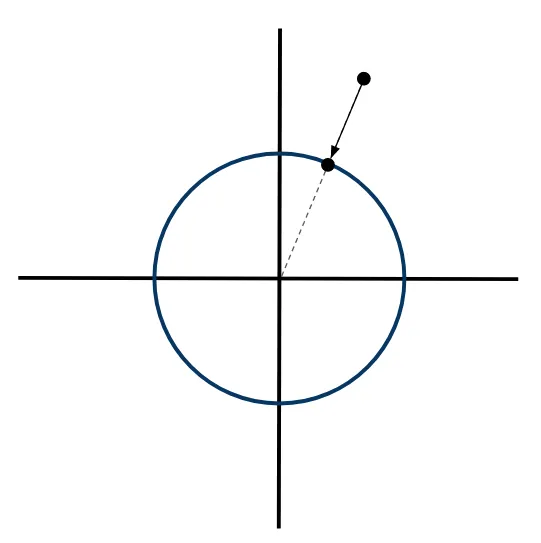
</div>

## Task 10: Implement PGD Attack
Your task is to implement the PGD attack. First, calculate the `attack budget` by determining the `max` $L_2$-norm difference of the benign updates from the global model. Then, use the `attack budget` in the PGD equation mentioned above to update $W_A^*$.


In [ ]:
norms_of_benign_updates = [model_dist_norm(benign_model, global_model_state_dict) for benign_model in benign_models]
# HINT:
# Compute the attack budget for the PGD (Projected Gradient Descent) attack
# As mentioned earlier, to simplify the process, use the maximum value of the current norms of benign updates
#
#
#(≈ 1 line of code)
# max_norms_of_benign_updates = ...
### IMPLEMENTATION START ###

### IMPLEMENTATION END ###
print("Max of actual benign norms:", max_norms_of_benign_updates)


def train_malicious_client_PGD(global_model_state_dict, local_training_data, local_epochs, lr=0.2, attack_budget=0):
    """
    :param global_model_state_dict: dictionary holding the parameters forming the layers of the current global model
    :param local_training_data: dataset of this malicious client for training
    :param local_epochs: number of local epochs
    :param lr: model learning rate
    :param attack_budget: radius of the l2 ball centered on the global_model
    :return state_dict containing the parameters of the trained model
    """

    global_model = ResNet18Light().to(COMPUTATION_DEVICE)
    global_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE)
    global_model.load_state_dict(global_model_state_dict)

    local_model = ResNet18Light().to(COMPUTATION_DEVICE)
    local_model.load_state_dict(global_model_state_dict)

    local_model.train()
    local_model.requires_grad_(True)
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)

    start_time = time.time()

    local_training_data = [(data.to(COMPUTATION_DEVICE), targets.to(COMPUTATION_DEVICE)) for data, targets in local_training_data]

    for local_epoch in range(local_epochs):

        epoch_loss = 0
        for batch_id, (data, targets) in enumerate(local_training_data):
            optimizer.zero_grad()
            targets = targets.to(COMPUTATION_DEVICE)
            output = local_model(data.to(COMPUTATION_DEVICE))
            predicted_classes = torch.argmax(output, dim=1)
            loss = cross_entropy(output,targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.detach().cpu()

        #if the distance of the local_model from the global model is bigger than the radius (attack budget)
        if model_dist_norm_var(local_model, global_model_state_dict) > attack_budget:

            result = {}

            # then we need to project back the model into a sphere with the global model as center
            for name, data in local_model.state_dict().items():
                # HINT:
                # if the layer is the one we are interested in, then:
                #   To obtain the projected model, apply the formula described earlier:
                #   multiply the attack budget by the model update (local model's layer minus global model's layer) divided by its norm, and add the global model's layer
                #
                # else:
                #   Simply copy the layer without any modifications
                #
                # The variable "data" holds the layer of the model update, while the variable "name" corresponds to the key for the same layer in the global_model_state_dict_on_cpu
                #
                # ATTENTION!!!
                # In this case, refrain from utilizing the function model_dist_norm(). Instead, employ the function torch.norm() to obtain the norm of the model update
                #
                #
                #(≈ 4 lines of code)
                # if name in NAMES_OF_AGGREGATED_PARAMETERS:
                #    result[...] = ...
                # else:
                #    result[...] = ...
                ### IMPLEMENTATION START ###




                ### IMPLEMENTATION END ###

            local_model.load_state_dict(result)


        epoch_loss = float(epoch_loss)
        elapsed = time.time() - start_time
        printing_prefix = '\t'
        print_timed(f'{printing_prefix}local_epoch {local_epoch:3d}'
                    f' | lr {lr} | ms/batch {elapsed * 1000:5.2f}'
                    f'| loss {epoch_loss:5.2f}')
        start_time = time.time()
    trained_local_weights = {name: param.detach().cpu() for name, param in local_model.state_dict().items()}
    local_training_data = [(data.cpu(), targets.cpu()) for data, targets in local_training_data]
    return trained_local_weights

In [ ]:
solution(key= " ")

#### Now, let's execute the implemented PGD attack by running the following code

In [ ]:
seed_everything(42)

# Reset the global model to R0099 for Poisoned PGD Federated Learning training
global_model_state_dict = torch.load('R0099.pt', map_location=COMPUTATION_DEVICE)
global_model.load_state_dict(global_model_state_dict)

# Poison the dataset of each malicious client with poison_dataset_targeted()
poisoned_local_datasets = []
for i in range(NUMBER_OF_MALICIOUS_CLIENTS):
    poisoned_local_datasets.append(poison_dataset_targeted(client_datasets[NUMBER_OF_BENIGN_CLIENTS + i], BACKDOOR_TARGET_LABEL))

# Train and Project each malicious client with train_malicious_client_PGD() using max_norms_of_benign_updates as the attack budget
PGD_models = []
for i in range(NUMBER_OF_MALICIOUS_CLIENTS):
    print(f'Start PGD Client {i}')
    locally_trained = train_malicious_client_PGD(global_model_state_dict, poisoned_local_datasets[i], lr=0.05, local_epochs=2, attack_budget=max_norms_of_benign_updates)
    PGD_models.append(locally_trained)
    print()

In [ ]:
# Evaluate MA and BA for the PGD attack

aggregated_model = ResNet18Light('AggregatedModel').to(COMPUTATION_DEVICE)
poisoned_weights = aggregate_models(global_model_state_dict, benign_models + PGD_models)
aggregated_model.load_state_dict(poisoned_weights)
print("Accuracy of Poisoned Aggregated Model:  ", end="")
evaluate_model(aggregated_model, test_data, backdoor_test_data_loader, COMPUTATION_DEVICE)

In [ ]:
# Visualize if the Projection of models helped keeping the malicious update hidden
plot_euclidian_distance(benign_models, PGD_models, global_model_state_dict)

In [ ]:
# Apply the Clustering defense and see which model are kept
indices_of_accepted_PGD_models = clustering_defense(benign_models + PGD_models, global_model_state_dict)
print(f'The defense accepted the following models in the PGD case:     {indices_of_accepted_PGD_models}')

In [ ]:
plot_accepted_models(indices_of_accepted_models=indices_of_accepted_PGD_models, benign_models=benign_models, poisoned_models=PGD_models, global_model_state_dict=global_model_state_dict)

In [ ]:
# Get the key metrics for the defense to understand its performance against the PGD attack
evaluate_model_filtering(indices_of_accepted_PGD_models, NUMBER_OF_MALICIOUS_CLIENTS, NUMBER_OF_BENIGN_CLIENTS)

#### Lastly, let's select only the models that the defense has filtered in and see if the PGD Backdoor is still present.

In [ ]:
aggregated_model = ResNet18Light('AggregatedModel').to(COMPUTATION_DEVICE)
filtered_in_models = []
for idx, model in enumerate(benign_models + PGD_models):
    #If the idx of the model is one of the idx of the model accepted by the Clustering Defense, we add the model for the aggregation
    if idx in indices_of_accepted_PGD_models:
        filtered_in_models.append(model)

poisoned_weights = aggregate_models(global_model_state_dict, filtered_in_models)
aggregated_model.load_state_dict(poisoned_weights)
print("Accuracy of PGD Poisoned Aggregated Model:  ", end="")
evaluate_model(aggregated_model, test_data, backdoor_test_data_loader, COMPUTATION_DEVICE)

#### The Projected Gradient Descent attack successfully evades our base Clustering Defense, making it difficult to detect the attack.

# Distributed Backdoor Attack (DBA)

Distributed Backdoor Attack refers to a type of attack where multiple malicious clients collaborate to inject backdoors into the global model. In DBA, the adversaries strategically break down the global trigger, which is the specific pattern or input that activates the backdoor behavior, into multiple local triggers.  

By dividing the global trigger into smaller, localized triggers, the malicious clients aim to distribute the backdoor presence across multiple models. Each client incorporates their own local trigger into their training process, ensuring that the backdoor behavior is not easily distinguishable in their individual models.

This attack specifically targets the dataset, which allows us to combine it with the C&S adaptive scaling technique to enhance the impact of the update.

Refer to Equation 3 in the research paper by ${\color{#3366BB}[5]}$ for more details.

[5] Xie, Chulin, et al. "Dba: Distributed backdoor attacks against federated learning." International conference on learning representations. 2020.
https://openreview.net/pdf?id=rkgyS0VFvr

An example of four local triggers (orange, green, yellow, blue) is used, and the global trigger is formed by combining all four triggers together.
<div align="center">
    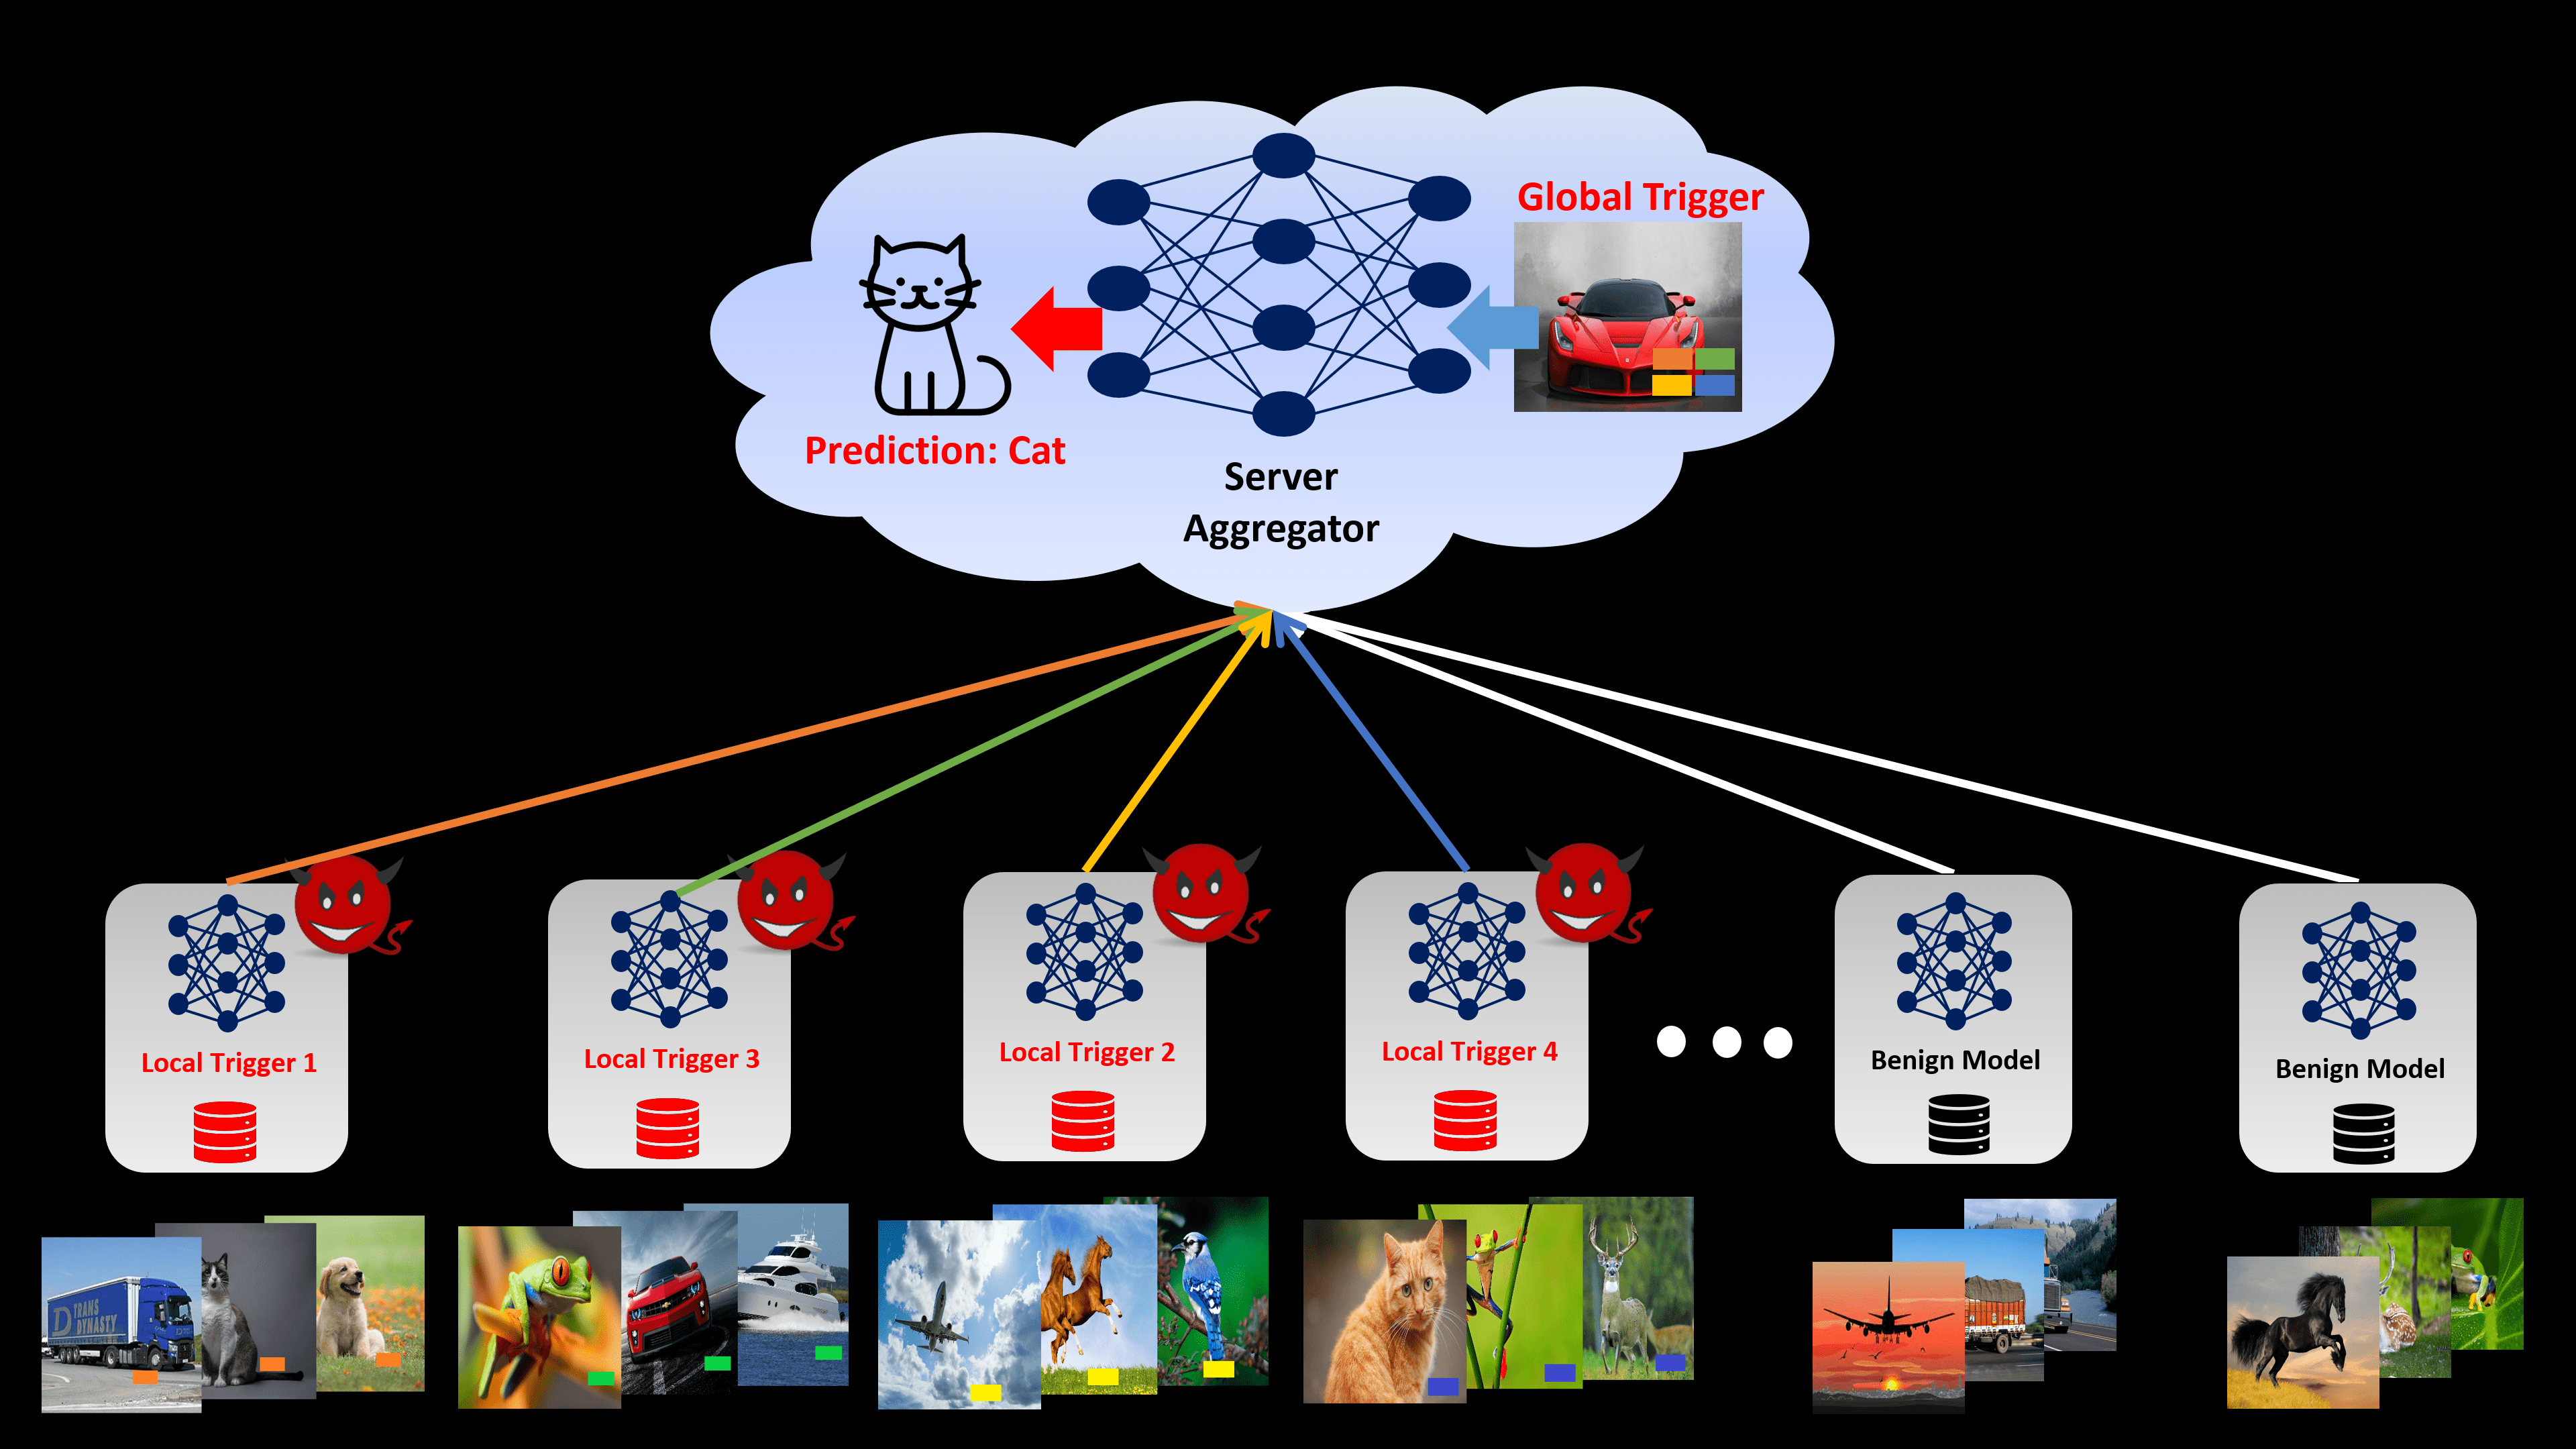
</div>

#### In our experiment, we will utilize four distinct local triggers.

## Task 11: Construct Local Triggers for DBA Attack

In this task, your objective is to create 4 local trigger functions for the Distributed Backdoor Attack (DBA) using the provided global_trigger and RGB values for each color. Running the following cell will display the composition of the global_trigger. Your task is to create separate local triggers by breaking down the global_trigger into its constituent parts. These local triggers will be used in the DBA attack.


In [ ]:
# Run this cell to display the composition of the global_trigger
def global_trigger(image):
    """
    Integrate a global trigger into an image
    :param image: image without a trigger
    :return the same image patched with a global trigger
    """
    triggered_image = image.clone()
    color = (torch.from_numpy(np.array([0.9294117647058824 , 0.49019607843137253 , 0.19215686274509805])) - MEAN) / STD_DEV #orange
    triggered_image[:, 26:28 :, 25:28] = color.repeat((3, 2, 1)).permute(2, 1, 0)
    color = (torch.from_numpy(np.array([0.4392156862745098 , 0.6784313725490196 , 0.2784313725490196])) - MEAN) / STD_DEV # green
    triggered_image[:, 26:28 :, 28:31] = color.repeat((3, 2, 1)).permute(2, 1, 0)
    color = (torch.from_numpy(np.array([1.0 , 0.7529411764705882 , 0.0])) - MEAN) / STD_DEV #yellow
    triggered_image[:, 28:30 :, 25:28] = color.repeat((3, 2, 1)).permute(2, 1, 0)
    color = (torch.from_numpy(np.array([0.3568627450980392 , 0.6078431372549019 , 0.8352941176470589])) - MEAN) / STD_DEV #blue
    triggered_image[:, 28:30 :, 28:31] = color.repeat((3, 2, 1)).permute(2, 1, 0)
    return triggered_image

plt.figure()
plot_image(unnormalize(global_trigger(example_image)))

In [ ]:
# Hint: Execute the this cell to obtain the RGB values corresponding to the color of each local trigger.
print("color     [         Red       ,       Green        ,        Blue         ]")

print("trigger 1 [", 237/255,",", 125/255,",", 49/255,"]")
print("trigger 2 [", 112/255,",", 173/255,",", 71/255,"]")
print("trigger 3 [", 255/255,",", 192/255,",", 0/255,"]")
print("trigger 4 [", 91/255,",", 155/255,",", 213/255,"]")

In [ ]:
def local_trigger_1(image):
    """
    Integrate a local trigger into an image
    :param image: image without a trigger
    :return the same image patched with a lcoal trigger
    """
    triggered_image = image.clone()
    # HINT:
    # Utilize the previous cell to retrieve the RGB values corresponding to the color of local trigger 1
    #
    #
    #(≈ 1 line of code)
    # color = (torch.from_numpy(np.array([ ... , ... , ... ])) - MEAN) / STD_DEV
    ### IMPLEMENTATION START ###

    ### IMPLEMENTATION END ###
    triggered_image[:, 26:28 :, 25:28] = color.repeat((3, 2, 1)).permute(2, 1, 0)
    return triggered_image

img_1 = unnormalize(local_trigger_1(example_image))
plt.figure()
plot_image(img_1)

In [ ]:
def local_trigger_2(image):
    """
    Integrate a local trigger into an image
    :param image: image without a trigger
    :return the same image patched with a lcoal trigger
    """
    triggered_image = image.clone()
    # HINT:
    # Utilize the previous cell to retrieve the RGB values corresponding to the color of local trigger 2
    #
    #
    #(≈ 1 line of code)
    # color = (torch.from_numpy(np.array([ ... , ... , ... ])) - MEAN) / STD_DEV
    ### IMPLEMENTATION START ###

    ### IMPLEMENTATION END ###
    triggered_image[:, 26:28 :, 28:31] = color.repeat((3, 2, 1)).permute(2, 1, 0)
    return triggered_image

img_2 = unnormalize(local_trigger_2(example_image))
plt.figure()
plot_image(img_2)

In [ ]:
def local_trigger_3(image):
    """
    Integrate a local trigger into an image
    :param image: image without a trigger
    :return the same image patched with a lcoal trigger
    """
    triggered_image = image.clone()
    # HINT:
    # Utilize the previous cell to retrieve the RGB values corresponding to the color of local trigger 3
    #
    #
    #(≈ 1 line of code)
    # color = (torch.from_numpy(np.array([ ... , ... , ... ])) - MEAN) / STD_DEV
    ### IMPLEMENTATION START ###

    ### IMPLEMENTATION END ###
    triggered_image[:, 28:30 :, 25:28] = color.repeat((3, 2, 1)).permute(2, 1, 0)
    return triggered_image

img_3 = unnormalize(local_trigger_3(example_image))
plt.figure()
plot_image(img_3)

In [ ]:
def local_trigger_4(image):
    """
    Integrate a local trigger into an image
    :param image: image without a trigger
    :return the same image patched with a lcoal trigger
    """
    triggered_image = image.clone()
    # HINT:
    # Utilize the previous cell to retrieve the RGB values corresponding to the color of local trigger 4
    #
    #
    #(≈ 1 line of code)
    # color = (torch.from_numpy(np.array([ ... , ... , ... ])) - MEAN) / STD_DEV
    ### IMPLEMENTATION START ###

    ### IMPLEMENTATION END ###
    triggered_image[:, 28:30 :, 28:31] = color.repeat((3, 2, 1)).permute(2, 1, 0)
    return triggered_image

img_4 = unnormalize(local_trigger_4(example_image))
plt.figure()
plot_image(img_4)

In [ ]:
solution(key= " ")

#### Now you can utilize the `poison_dataset_DBA` function to execute the Distributed Backdoor Attack (DBA) using different `trigger_function` such as global_trigger, local_trigger_1, and so on.


In [ ]:
# Use this function call to test your implementation
poison_dataset_DBA(client_datasets[NUMBER_OF_BENIGN_CLIENTS], 2, trigger_function=global_trigger, pdr= 1/3, print_number_of_poisoned_images=True)

# Poison the Test Dataset to evaluate the Backdoor Accuracy of the Distributed Backdoor Attack
DBA_test_data_loader = poison_dataset_DBA(test_data, BACKDOOR_TARGET_LABEL, trigger_function=global_trigger, pdr= 1, batch_size=TEST_BATCH_SIZE)

#### Let's proceed with training the malicious clients using the locally triggered dataset and the `train_malicious_client` function with C&S.

In [ ]:
seed_everything(42)
local_trigger_DBA_datasets = []

# Create the specific Poisoned Dataset for each client
# We evenly split the clients in 4 group, each using one of the four local_trigger_N function
for idx in range(NUMBER_OF_MALICIOUS_CLIENTS):
    trigger = i % 4 + 1
    trigger_function = None

    # Choose local trigger N
    if trigger == 1:
        trigger_function = local_trigger_1
    elif trigger == 2:
        trigger_function = local_trigger_2
    elif trigger == 3:
        trigger_function = local_trigger_3
    elif trigger == 4:
        trigger_function = local_trigger_4

    # The malicious client idx will poison his dataset with the local trigger N
    local_trigger_DBA_datasets.append(poison_dataset_DBA(client_datasets[NUMBER_OF_BENIGN_CLIENTS + idx], BACKDOOR_TARGET_LABEL, trigger_function=trigger_function, pdr=0.9))

# Train each malicious client with a conjunction of C&S with train_malicious_client() and DBA using local_trigger_DBA_datasets as the local dataset
evasion_scaled_DBA_models = []
for client_index in range(NUMBER_OF_MALICIOUS_CLIENTS):
    print(f'Start DBA Client {client_index}')
    locally_trained = train_malicious_client(global_model_state_dict, local_trigger_DBA_datasets[client_index], lr=0.5, local_epochs=1, alpha=0.55)

    unscaled_norm = model_dist_norm(global_model_state_dict_on_cpu, locally_trained)

    evasion_scaling_factor = median_norms_of_benign_updates / unscaled_norm #Norm for Evasion scaling factor

    print_timed(f'\tEvasion scaling Factor: {evasion_scaling_factor}')

    scaled_locally_trained = scale_update(global_model_state_dict_on_cpu, locally_trained, evasion_scaling_factor)
    print_timed(f'\tL2 Norm: {model_dist_norm(global_model_state_dict_on_cpu, scaled_locally_trained)}')
    evasion_scaled_DBA_models.append(scaled_locally_trained)

In [ ]:
# Evaluate MA and BA for the DBA attack

aggregated_model = ResNet18Light('AggregatedModel').to(COMPUTATION_DEVICE)
poisoned_weights = aggregate_models(global_model_state_dict, benign_models + evasion_scaled_DBA_models)
aggregated_model.load_state_dict(poisoned_weights)
print("Accuracy of DBA Models Aggregation:   ", end="")
evaluate_model(aggregated_model, test_data, DBA_test_data_loader, COMPUTATION_DEVICE)

In [ ]:
# Visualize if the Projection of models helped keeping the malicious update hidden
plot_euclidian_distance(benign_models, evasion_scaled_DBA_models, global_model_state_dict)

In [ ]:
# Apply the Clustering defense and see which model are kept
indices_of_accepted_evasion_scaled_DBA_models = clustering_defense(benign_models + evasion_scaled_DBA_models, global_model_state_dict)
print(f'The defense accepted the following models in the DBA Evasion Scale case:     {indices_of_accepted_evasion_scaled_DBA_models}')

In [ ]:
plot_accepted_models(indices_of_accepted_evasion_scaled_DBA_models, benign_models, evasion_scaled_DBA_models, global_model_state_dict)

In [ ]:
# Get the key metrics for the defense to understand its performance against the DBA attack
evaluate_model_filtering(indices_of_accepted_evasion_scaled_DBA_models, NUMBER_OF_MALICIOUS_CLIENTS, NUMBER_OF_BENIGN_CLIENTS)

#### Lastly, let's select only the models that the defense has filtered in and see if the Global Backdoor is still present.

In [ ]:
aggregated_model = ResNet18Light('AggregatedModel').to(COMPUTATION_DEVICE)
filtered_in_models = []
for idx, model in enumerate(benign_models + evasion_scaled_DBA_models):
    #If the idx of the model is one of the idx of the model accepted by the Clustering Defense, we add the model for the aggregation
    if idx in indices_of_accepted_evasion_scaled_DBA_models:
        filtered_in_models.append(model)

poisoned_weights = aggregate_models(global_model_state_dict, filtered_in_models)
aggregated_model.load_state_dict(poisoned_weights)
print("Accuracy of DBA Poisoned Aggregated Model:  ", end="")
evaluate_model(aggregated_model, test_data, backdoor_test_data_loader, COMPUTATION_DEVICE)

#### The Distributed Backdoor Attack (DBA) using the Constran & Scale technique effectively hides its update from our base Clustering Defense, leading to a notable improvement in Backdoor Accuracy (BA).